# Pre- processing

### Import necessary libraries #

In [35]:
import sys, traceback
import cv2
import numpy as np
import argparse
import string
from plantcv import plantcv as pcv
from scipy.misc import toimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import skimage
import math
import pandas as pd
from sklearn import svm
import sklearn.metrics as metric
%matplotlib inline
import warnings

### Read an image

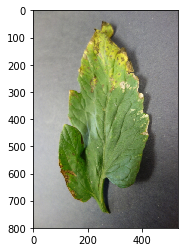

In [2]:
destfile='/home/shivani/6sem/minorproject/bacterialSpot/b1.jpg'
img = mpimg.imread(destfile)
plt.imshow(img)
plt.show()

### Read images from directory

In [3]:
import os
import glob
img_dir = "/home/shivani/6sem/minorproject/bacterialSpot" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*jpg')
files = glob.glob(data_path)
data = []
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)

### Apply filters to the image

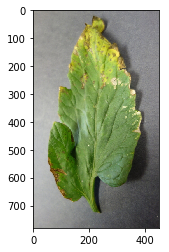

In [13]:
class Filter:
    pass

##
# Convolution filter kernel.
image=  cv2.imread('/home/shivani/6sem/minorproject/bacterialSpot/b1.jpg')

class Kernel(Filter):

    ##
    # Create a convolution kernel.  The current version only
    # supports 3x3 and 5x5 integer and floating point kernels.
    # <p>
    # In the current version, kernels can only be applied to
    # "L" and "RGB" images.
    #
    # @def __init__(size, kernel, **options)
    # @param size Kernel size, given as (width, height).  In
    #    the current version, this must be (3,3) or (5,5).
    # @param kernel A sequence containing kernel weights.
    # @param **options Optional keyword arguments.
    # @keyparam scale Scale factor.  If given, the result for each
    #    pixel is divided by this value.  The default is the sum
    #    of the kernel weights.
    # @keyparam offset Offset.  If given, this value is added to the
    #    result, after it has been divided by the scale factor.
    def __init__(self, size, kernel, scale=None, offset=0):
        if scale is None:
            # default scale is sum of kernel
            scale = reduce(lambda a,b: a+b, kernel)
        if size[0] * size[1] != len(kernel):
            raise ValueError("not enough coefficients in kernel")
        self.filterargs = size, scale, offset, kernel

    def filter(self, image):
        if image.mode == "P":
            raise ValueError("cannot filter palette images")
        return apply(image.filter, self.filterargs)

class BuiltinFilter(Kernel):
    def __init__(self):
        pass

##
# Rank filter.

class RankFilter(Filter):
    name = "Rank"

    ##
    # Create a rank filter.  The rank filter sorts all pixels in
    # a window of the given size, and returns the rank'th value.
    #
    # @param size The kernel size, in pixels.
    # @param rank What pixel value to pick.  Use 0 for a min filter,
    #    size*size/2 for a median filter, size*size-1 for a max filter,
    #    etc.

    def __init__(self, size, rank):
        self.size = size
        self.rank = rank

    def filter(self, image):
        if image.mode == "P":
            raise ValueError("cannot filter palette images")
        image = image.expand(self.size/2, self.size/2)
        return image.rankfilter(self.size, self.rank)

##
# Median filter.  Picks the median pixel value in a window with the
# given size.

class MedianFilter(RankFilter):
    name = "Median"

    ##
    # Create a median filter.
    #
    # @param size The kernel size, in pixels.

    def __init__(self, size=3):
        self.size = size
        self.rank = size*size/2

##
# Min filter.  Picks the lowest pixel value in a window with the given
# size.

class MinFilter(RankFilter):
    name = "Min"

    ##
    # Create a min filter.
    #
    # @param size The kernel size, in pixels.

    def __init__(self, size=3):
        self.size = size
        self.rank = 0

##
# Max filter.  Picks the largest pixel value in a window with the
# given size.

class MaxFilter(RankFilter):
    name = "Max"

    ##
    # Create a max filter.
    #
    # @param size The kernel size, in pixels.

    def __init__(self, size=3):
        self.size = size
        self.rank = size*size-1

##
# Mode filter.  Picks the most frequent pixel value in a box with the
# given size.  Pixel values that occur only once or twice are ignored;
# if no pixel value occurs more than twice, the original pixel value
# is preserved.

class ModeFilter(Filter):
    name = "Mode"

    ##
    # Create a mode filter.
    #
    # @param size The kernel size, in pixels.

    def __init__(self, size=3):
        self.size = size
    def filter(self, image):
        return image.modefilter(self.size)

##
# Gaussian blur filter.

class GaussianBlur(Filter):
    name = "GaussianBlur"

    def __init__(self, radius=2):
        self.radius = 2
    def filter(self, image):
        return image.gaussian_blur(self.radius)

##
# Unsharp mask filter.

class UnsharpMask(Filter):
    name = "UnsharpMask"

    def __init__(self, radius=2, percent=150, threshold=3):
        self.radius = 2
        self.percent = percent
        self.threshold = threshold
    def filter(self, image):
        return image.unsharp_mask(self.radius, self.percent, self.threshold)

##
# Simple blur filter.

class BLUR(BuiltinFilter):
    name = "Blur"
    filterargs = (5, 5), 16, 0, (
        1,  1,  1,  1,  1,
        1,  0,  0,  0,  1,
        1,  0,  0,  0,  1,
        1,  0,  0,  0,  1,
        1,  1,  1,  1,  1
        )

##
# Simple contour filter.

class CONTOUR(BuiltinFilter):
    name = "Contour"
    filterargs = (3, 3), 1, 255, (
        -1, -1, -1,
        -1,  8, -1,
        -1, -1, -1
        )

##
# Simple detail filter.

class DETAIL(BuiltinFilter):
    name = "Detail"
    filterargs = (3, 3), 6, 0, (
        0, -1,  0,
        -1, 10, -1,
        0, -1,  0
        )

##
# Simple edge enhancement filter.

class EDGE_ENHANCE(BuiltinFilter):
    name = "Edge-enhance"
    filterargs = (3, 3), 2, 0, (
        -1, -1, -1,
        -1, 10, -1,
        -1, -1, -1
        )

##
# Simple stronger edge enhancement filter.

class EDGE_ENHANCE_MORE(BuiltinFilter):
    name = "Edge-enhance More"
    filterargs = (3, 3), 1, 0, (
        -1, -1, -1,
        -1,  9, -1,
        -1, -1, -1
        )

##
# Simple embossing filter.

class EMBOSS(BuiltinFilter):
    name = "Emboss"
    filterargs = (3, 3), 1, 128, (
        -1,  0,  0,
        0,  1,  0,
        0,  0,  0
        )

##
# Simple edge-finding filter.

class FIND_EDGES(BuiltinFilter):
    name = "Find Edges"
    filterargs = (3, 3), 1, 0, (
        -1, -1, -1,
        -1,  8, -1,
        -1, -1, -1
        )

##
# Simple smoothing filter.

class SMOOTH(BuiltinFilter):
    name = "Smooth"
    filterargs = (3, 3), 13, 0, (
        1,  1,  1,
        1,  5,  1,
        1,  1,  1
        )

##
# Simple stronger smoothing filter.

class SMOOTH_MORE(BuiltinFilter):
    name = "Smooth More"
    filterargs = (5, 5), 100, 0, (
        1,  1,  1,  1,  1,
        1,  5,  5,  5,  1,
        1,  5, 44,  5,  1,
        1,  5,  5,  5,  1,
        1,  1,  1,  1,  1
        )

##
# Simple sharpening filter.

class SHARPEN(BuiltinFilter):
    name = "Sharpen"
    filterargs = (3, 3), 16, 0, (
        -2, -2, -2,
-2, 32, -2,
        -2, -2, -2
)
    


from PIL import Image

def crop(image_path, coords, saved_location):

    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)

    #cropped_image.show()
    plt.imshow(cropped_image)

if __name__ == '__main__':
    crop('/home/shivani/6sem/minorproject/bacterialSpot/b1.jpg', (40, 20, 490, 800), '/home/shivani/6sem/minorproject/bf1.png')

### Crop the image

In [2]:
from PIL import Image

def crop(image_path, coords, saved_location):

    """
    @param image_path: The path to the image to edit

    @param coords: A tuple of x/y coordinates (x1, y1, x2, y2)

    @param saved_location: Path to save the cropped image
    """

    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)

    #cropped_image.show()
    #plt.imshow(cropped_image)

if __name__ == '__main__':
    crop('/home/shivani/6sem/minorproject/bacterial/b1.png', (40, 20, 490, 800), '/home/shivani/6sem/minorproject/bacterial/crop/b1.jpg')


### Crop images in the directory

In [113]:
import sys
import os
from PIL import Image


filepath = "/home/shivani/6sem/minorproject/bact"

# Loop through all provided arguments
for filename in os.listdir(filepath):
    if "." not in filename:
        continue
    ending = filename.split(".")[1]
    if ending not in ["jpg", "gif", "png"]:
        continue

    try:
        # Attempt to open an image file
        image = Image.open(os.path.join(filepath, filename))
    except (IOError, e):
        # Report error, and then skip to the next argument
        print ("Problem opening", filepath, ":", e)
        continue

    # Perform operations on the image here
    image = image.crop((40, 20, 490, 800))

    # Split our origional filename into name and extension 
    name, extension = os.path.splitext(filename)

    # Save the image as "(origional_name)_thumb.jpg
   # print(name + '_cropped.jpg')
    #print("images cropped")
    image.save(os.path.join("/home/shivani/6sem/minorproject/bact", name + 'crop.png'))
    


filepath = "/home/shivani/6sem/minorproject/bacterialSpot"

# Loop through all provided arguments
for filename in os.listdir(filepath):
    if "." not in filename:
        continue
    ending = filename.split(".")[1]
    if ending not in ["jpg", "gif", "png"]:
        continue

    try:
        # Attempt to open an image file
        image = Image.open(os.path.join(filepath, filename))
    except (IOError, e):
        # Report error, and then skip to the next argument
        print ("Problem opening", filepath, ":", e)
        continue

    # Perform operations on the image here
    image = image.crop((40, 20, 490, 800))

    # Split our origional filename into name and extension 
    name, extension = os.path.splitext(filename)

    # Save the image as "(origional_name)_thumb.jpg
   # print(name + '_cropped.jpg')
    #print("images cropped")
 

### Convert to HSV image

In [248]:
import cv2
import numpy as np
img=cv2.imread('/home/shivani/6sem/minorproject/bf1.png')

hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)


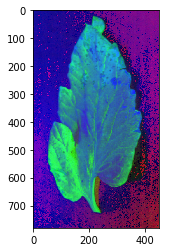

In [249]:
plt.imshow(hsv)

# Segmentation

### Binarization of image

#### 1. Global Thresholding




#### 2. Adaptive Mean Thresholding


#### 3. Adaptive Gaussian Thresholding

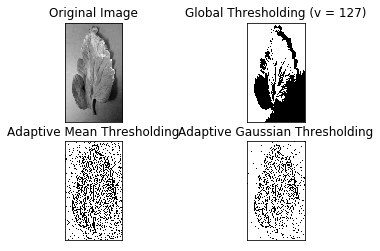

In [84]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('/home/shivani/6sem/minorproject/bactgrey/crop/c1.png',0)
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

#### Otsu's Thresholding

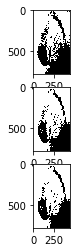

In [85]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('/home/shivani/6sem/minorproject/bactgrey/crop/c1.png',0)


# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
#titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
#       'Original Noisy Image','Histogram',"Otsu's Thresholding",
#          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    #plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    #plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    #plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    #plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    #plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

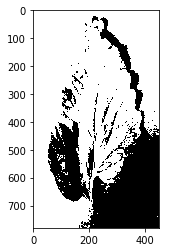

In [129]:
from numpy import array
import PIL.ImageOps

#img numpy array
img = cv2.imread('/home/shivani/6sem/minorproject/bactgrey/crop/c1.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,500,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#ret, thresh

#img to numpy and invert img colors
im = Image.fromarray(thresh)
inverted_image = PIL.ImageOps.invert(im)
#im.save('/home/hp/Desktop/greyscale1g.png')
inverted_image.save('/home/shivani/6sem/minorproject/bactgrey/binary/o1.png')

plt.imshow(inverted_image)

#### Watershed Algorithm

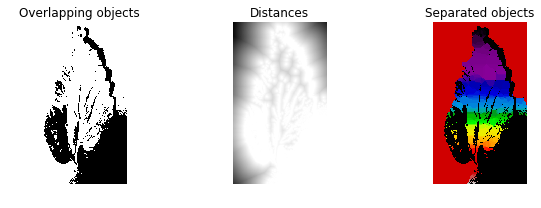

In [164]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max


image = cv2.imread('/home/shivani/6sem/minorproject/bactgrey/binary/o1.png',0)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()



#### Canny Edge detection

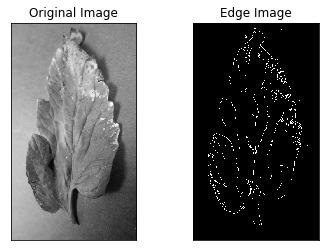

In [141]:

import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('/home/shivani/6sem/minorproject/bactgrey/crop/c1.png',0)
edges = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

#### Foreground extraction using grab cut algorithm

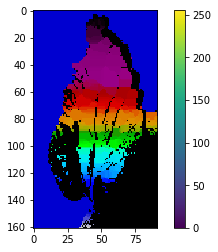

(<matplotlib.image.AxesImage at 0x7f1648cb1e10>,
 None)

In [147]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('/home/shivani/6sem/minorproject/watershed/w1.png')
mask = np.zeros(img.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (50,50,450,300)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==2),1,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

plt.imshow(img),plt.colorbar(),plt.show()

#### Obtain binarization histogram

Threshold: 115


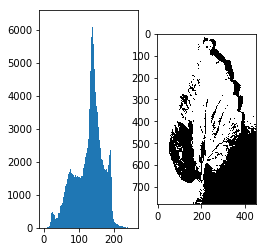

In [148]:
import warnings
warnings.filterwarnings('ignore')
# Juan Miguel Valverde Martinez
# http://laid.delanover.com

import numpy as np
import cv2
from matplotlib import pyplot as plt


im = cv2.imread("/home/shivani/6sem/minorproject/bactgrey/crop/c1.png",0)
im_flat = np.reshape(im,(im.shape[0]*im.shape[1]))

[hist, _] = np.histogram(im, bins=256, range=(0, 255))
# Normalization so we have probabilities-like values (sum=1)
hist = 1.0*hist/np.sum(hist)

val_max = -999
thr = -1
for t in range(1,255):
    # Non-efficient implementation
    q1 = np.sum(hist[:t])
    q2 = np.sum(hist[t:])
    m1 = np.sum(np.array([i for i in range(t)])*hist[:t])/q1
    m2 = np.sum(np.array([i for i in range(t,256)])*hist[t:])/q2
    val = q1*(1-q1)*np.power(m1-m2,2)
    if val_max < val:
        val_max = val
        thr = t

print("Threshold: {}".format(thr))


#plt.subplot(131)
#plt.imshow(im, cmap = 'gray')
plt.subplot(132)
plt.hist(im_flat, bins=256, range=(0, 255))
plt.subplot(133)
plt.imshow(im > thr, cmap = 'gray')
plt.show()

#### Obtain rgb intensity

In [149]:
import cv2
image = cv2.imread("/home/shivani/6sem/minorproject/bacterial/b1.png")
print(image.shape)

(800, 533, 3)


In [150]:
raw = image.flatten()
raw.shape


(1279200,)

In [151]:
raw

array([138, 144, 143, ...,  35,  38,  46], dtype=uint8)

In [152]:
means = cv2.mean(image)
means

(110.32083255159475, 136.4264962476548, 128.1025469043152, 0.0)

In [153]:
means = means[:3]
means

(110.32083255159475, 136.4264962476548, 128.1025469043152)

In [154]:
(means, stds) = cv2.meanStdDev(image)
means, stds

(array([[110.32083255],
        [136.42649625],
        [128.1025469 ]]), array([[49.9732565 ],
        [41.58452468],
        [42.80718924]]))

In [155]:
import numpy as np
stats = np.concatenate([means, stds]).flatten()
stats

array([110.32083255, 136.42649625, 128.1025469 ,  49.9732565 ,
        41.58452468,  42.80718924])

In [156]:
hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
hist.shape

(8, 8, 8)

In [157]:
hist = hist.flatten()
hist.shape

(512,)

In [158]:
import matplotlib as plt
np.histogram(hist)

(array([505,   2,   3,   0,   1,   0,   0,   0,   0,   1]),
 array([     0. ,  10597.4,  21194.8,  31792.2,  42389.6,  52987. ,
         63584.4,  74181.8,  84779.2,  95376.6, 105974. ], dtype=float32))

In [159]:
img = cv2.imread('/home/shivani/6sem/minorproject/bacterial/b1.png',0)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
hist,bins = np.histogram(img.ravel(),256,[0,256])

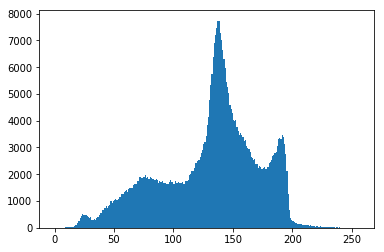

In [160]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('/home/shivani/6sem/minorproject/bacterial/b1.png',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()

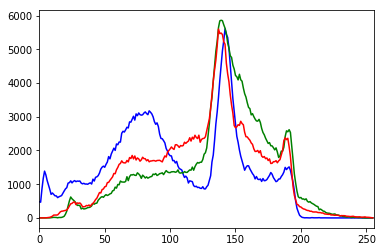

In [164]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('/home/shivani/6sem/minorproject/bacterial/crop/b1.png')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

### Extract affected portion of leaf

In [41]:

warnings.filterwarnings('ignore')
import numpy as np
from skimage import io, color, img_as_ubyte
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy


In [42]:
ent=entropy(grayImg)


In [719]:
import numpy as np
from skimage import feature, io
from sklearn import preprocessing
warnings.filterwarnings('ignore')

img = io.imread("/home/shivani/6sem/minorproject/color/bin1.png", as_grey=True)

S = preprocessing.MinMaxScaler((0,11)).fit_transform(img).astype(int)
Grauwertmatrix = feature.greycomatrix(S, [1,2], [0, np.pi/4, np.pi/2], levels=12, symmetric=True, normed=True)

ContrastStats = feature.greycoprops(Grauwertmatrix, 'contrast')
CorrelationtStats = feature.greycoprops(Grauwertmatrix, 'correlation')
HomogeneityStats = feature.greycoprops(Grauwertmatrix, 'homogeneity')
EnergyStats = feature.greycoprops(Grauwertmatrix, 'energy')
#EntropyStats = feature.greycoprops(Grauwertmatrix, 'entropy')
ent=entropy(img)

#print([np.mean(ContrastStats), np.mean(CorrelationtStats),\
#np.mean(ASMStats), np.mean(HomogeneityStats)])


In [720]:
print("Contrast:\n",ContrastStats,"\n")
print("Correlation:\n",CorrelationtStats,"\n")
print("Homogeneity:\n",HomogeneityStats,"\n")
print("Energy:\n",EnergyStats,"\n")

Contrast:
 [[1.21476786 1.49584728 1.00099843]
 [2.211962   1.49584728 1.83037989]] 

Correlation:
 [[0.89387411 0.86947691 0.91247159]
 [0.80716398 0.86947691 0.84014426]] 

Homogeneity:
 [[0.99004289 0.98773896 0.99179509]
 [0.98186916 0.98773896 0.98499689]] 

Energy:
 [[0.94628874 0.94502718 0.94724923]
 [0.94194184 0.94502718 0.94364823]] 



In [721]:
cos=np.mean(ContrastStats)
corr=np.mean(CorrelationtStats)
hom=np.mean(HomogeneityStats)
asm=np.mean(EnergyStats)
print("Contrast:\n",cos,"\n")
print("Correlation:\n",corr,"\n")
print("Homogeneity:\n",hom,"\n")
print("Energy:\n",asm,"\n")
print("Entropy:\n",ent)

Contrast:
 1.5416337908181301 

Correlation:
 0.8654346258667011 

Homogeneity:
 0.9873636574523105 

Energy:
 0.9448637342484769 

Entropy:
 0.19753259162494652


In [722]:
print(cos,",",corr,",",hom,",",asm,",",ent)

1.5416337908181301 , 0.8654346258667011 , 0.9873636574523105 , 0.9448637342484769 , 0.19753259162494652


In [723]:
m=np.mean(img)
m


12.665

In [724]:
s=np.std(img)
s


55.40011529771397

#### 2. Septoria

In [47]:

## Read
img = cv2.imread('/home/shivani/6sem/minorproject/septoria/rgb/sep5.jpg')

## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

## mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
mask = cv2.inRange(hsv, (10,25,25), (120,90,190))

## slice the green
imask = mask>0
green = np.zeros_like(img, np.uint8)
green[imask] = img[imask]

## save 
cv2.imwrite("/home/shivani/6sem/minorproject/septoria/rgbcolor/sep5.png", green)


True

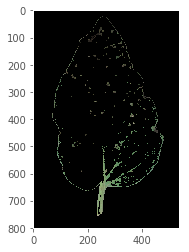

In [50]:
from PIL import Image

%matplotlib inline  
plt.rcParams["axes.grid"] = False
#Import an image
image = Image.open("/home/shivani/6sem/minorproject/septoria/rgbcolor/sep5.png")

plt.imshow(image)

In [45]:
import numpy as np
from sklearn.metrics.cluster import entropy
from skimage import feature, io
from sklearn import preprocessing
warnings.filterwarnings('ignore')

img = io.imread("/home/shivani/6sem/minorproject/septoria/rgbcolor/sep1.png", as_grey=True)

S = preprocessing.MinMaxScaler((0,11)).fit_transform(img).astype(int)
Grauwertmatrix = feature.greycomatrix(S, [1,2], [0, np.pi/4, np.pi/2], levels=12, symmetric=True, normed=True)

ContrastStats = feature.greycoprops(Grauwertmatrix, 'contrast')
CorrelationtStats = feature.greycoprops(Grauwertmatrix, 'correlation')
HomogeneityStats = feature.greycoprops(Grauwertmatrix, 'homogeneity')
EnergyStats = feature.greycoprops(Grauwertmatrix, 'energy')
#EntropyStats = feature.greycoprops(Grauwertmatrix, 'entropy')
ent=entropy(img)

In [713]:
print("Contrast:\n",ContrastStats,"\n")
print("Correlation:\n",CorrelationtStats,"\n")
print("Homogeneity:\n",HomogeneityStats,"\n")
print("Energy:\n",EnergyStats,"\n")

Contrast:
 [[0.57600435 0.69297491 0.50472379]
 [0.83289199 0.69297491 0.67868891]] 

Correlation:
 [[0.67730293 0.61224909 0.71710136]
 [0.53398108 0.61224909 0.62006157]] 

Homogeneity:
 [[0.98503453 0.98228229 0.98711973]
 [0.97975094 0.98228229 0.98371912]] 

Energy:
 [[0.97316758 0.97138661 0.97274004]
 [0.97032278 0.97138661 0.97108646]] 



In [714]:
cos=np.mean(ContrastStats)
corr=np.mean(CorrelationtStats)
hom=np.mean(HomogeneityStats)
asm=np.mean(EnergyStats)
print("Conrast:\n",cos,"\n")
print("Correlation:\n",corr,"\n")
print("Homoeneity:\n",hom,"\n")
print("Energy:\n",asm,"\n")
print("Entropy:\n",ent)

Conrast:
 0.6630431431551863 

Correlation:
 0.628824188432068 

Homoeneity:
 0.98336481913064 

Energy:
 0.9716816815190047 

Entropy:
 0.2516000443393523


In [715]:
print(cos,",",corr,",",hom,",",asm,",",ent)

0.6630431431551863 , 0.628824188432068 , 0.98336481913064 , 0.9716816815190047 , 0.2516000443393523


In [716]:
m=np.mean(img)
m


0.005188043441925381

In [718]:
s=np.std(img)
s


0.04311280688896396

#### 3. Yellow curved

In [841]:

## Read
img = cv2.imread('/home/shivani/6sem/minorproject/yellowcurved/rgb/y1.jpg')

## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

## mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
mask = cv2.inRange(hsv, (40,60,70), (70,120,120))

## slice the green
imask = mask>0
green = np.zeros_like(img, np.uint8)
green[imask] = img[imask]

## save 
cv2.imwrite("/home/shivani/6sem/minorproject/yellowcurved/rgbcolor/y1.png", green)


True

In [839]:
x=[1,1,1,2,2,4,2,3,2,2,4,2,4,5,2,4,5,2,3,3,1,1,2,5,5,2,4,4,3,5,2,5,5,5,2,2,2,2,5,5,3,4,2,4,5,1,1,2,5,5]
y=0.8102

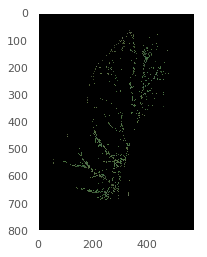

In [842]:
from PIL import Image

%matplotlib inline  
plt.rcParams["axes.grid"] = False
#Import an image
image = Image.open("/home/shivani/6sem/minorproject/yellowcurved/rgbcolor/y1.png")

plt.imshow(image)

In [843]:

warnings.filterwarnings('ignore')

img = io.imread("/home/shivani/6sem/minorproject/yellowcurved/rgbcolor/y1.png", as_grey=True)

S = preprocessing.MinMaxScaler((0,11)).fit_transform(img).astype(int)
Grauwertmatrix = feature.greycomatrix(S, [1,2], [0, np.pi/4, np.pi/2], levels=12, symmetric=True, normed=True)

ContrastStats = feature.greycoprops(Grauwertmatrix, 'contrast')
CorrelationtStats = feature.greycoprops(Grauwertmatrix, 'correlation')
HomogeneityStats = feature.greycoprops(Grauwertmatrix, 'homogeneity')
EnergyStats = feature.greycoprops(Grauwertmatrix, 'energy')
#EntropyStats = feature.greycoprops(Grauwertmatrix, 'entropy')
ent=entropy(img)

In [844]:
print("Contrast:\n",ContrastStats,"\n")
print("Correlation:\n",CorrelationtStats,"\n")
print("Homogeneity:\n",HomogeneityStats,"\n")
print("Energy:\n",EnergyStats,"\n")

Contrast:
 [[2.18003913 2.39618654 2.17852611]
 [2.57308362 2.39618654 2.56635948]] 

Correlation:
 [[0.41671845 0.3596694  0.41684617]
 [0.31272611 0.3596694  0.31386927]] 

Homogeneity:
 [[0.96980249 0.96739937 0.96981868]
 [0.96548697 0.96739937 0.9657115 ]] 

Energy:
 [[0.96328161 0.9619186  0.96333814]
 [0.96070801 0.9619186  0.96081514]] 



In [845]:
cos=np.mean(ContrastStats)
corr=np.mean(CorrelationtStats)
hom=np.mean(HomogeneityStats)
asm=np.mean(EnergyStats)
print("Conrast:\n",cos,"\n")
print("Correlation:\n",corr,"\n")
print("Homoeneity:\n",hom,"\n")
print("Energy:\n",asm,"\n")
print("Entropy:\n",ent)

Conrast:
 2.3817302355448944 

Correlation:
 0.3632497990136676 

Homoeneity:
 0.9676030626295621 

Energy:
 0.9619966839340425 

Entropy:
 0.30611614989544855


In [846]:
print(cos,",",corr,",",hom,",",asm,",",ent)

2.3817302355448944 , 0.3632497990136676 , 0.9676030626295621 , 0.9619966839340425 , 0.30611614989544855


In [847]:
m=np.mean(img)
m


0.00873187055589597

In [848]:
s=np.std(img)
s


0.0566559745669736